# The Black–Scholes Model

### 1. Purpose
The **Black–Scholes model** provides a theoretical framework for pricing **European options** — options that can only be exercised at maturity.

It assumes:
- Efficient markets (no arbitrage)
- Continuous trading
- Constant volatility and interest rates
- Lognormal stock price dynamics

---

### 2. Model Setup

Let:
- \( S_t \): price of the underlying asset at time \( t \)
- \( K \): strike price (fixed)
- \( T \): time to maturity
- \( r \): constant risk-free interest rate
- \( \sigma \): constant volatility
- \( W_t \): Wiener process (Brownian motion)

Then, under the **risk-neutral measure** \( \mathbb{Q} \):

$$
dS_t = r S_t \, dt + \sigma S_t \, dW_t
$$

This is a **geometric Brownian motion**.

---

### 3. Option Payoffs

- **Call option payoff:**  
  $$
  \max(S_T - K, 0)
  $$

- **Put option payoff:**  
  $$
  \max(K - S_T, 0)
  $$

---

### 4. The Black–Scholes PDE

Any derivative price \( V(S, t) \) satisfies the **Black–Scholes partial differential equation**:

$$
\frac{\partial V}{\partial t}
+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
+ rS \frac{\partial V}{\partial S}
- rV = 0
$$

Boundary conditions depend on the option type:
- For a call: $ V(S, T) = \max(S - K, 0) $
- For a put: $ V(S, T) = \max(K - S, 0) $

---

### 5. Solution (Closed-Form Formula)

The **European Call Option Price**:

$$
C(S_0, t) = S_0 N(d_1) - K e^{-r(T-t)} N(d_2)
$$

The **European Put Option Price**:

$$
P(S_0, t) = K e^{-r(T-t)} N(-d_2) - S_0 N(-d_1)
$$

where:

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)(T-t)}{\sigma \sqrt{T-t}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T-t}
$$

and \( N(x) \) is the **cumulative distribution function** of the standard normal distribution.

---

### 6. Interpretation of Terms

| Symbol | Meaning |
|:--|:--|
| $ N(d_1) $ | Probability (under risk-neutral measure) that the option will be exercised |
| $ N(d_2) $ | Probability (discounted for the strike payment) that the option ends in the money |
| $ S_0 N(d_1) $ | Present value of expected asset payoff |
| $ K e^{-rT} N(d_2) $ | Present value of expected strike payment |

---

### 7. The Greeks (Sensitivities)

| Greek | Definition | Intuition |
|:--|:--|:--|
| $ \Delta = N(d_1) $ | Change in option price per $1$ change in $ S $ |
| $ \Gamma = \frac{N'(d_1)}{S_0 \sigma \sqrt{T-t}} $ | Sensitivity of $ \Delta $ to $ S $ (curvature) |
| $ \Theta $ | Time decay of option value |
| $ \text{Vega} = S_0 N'(d_1)\sqrt{T-t} $ | Sensitivity to volatility |
| $ \rho = K (T-t)e^{-r(T-t)} N(d_2) $ | Sensitivity to interest rate |

---

### 8. Economic Intuition

- The model assumes investors can **eliminate risk** by continuously hedging.
- Therefore, all options can be priced as **risk-free discounted expectations**:
  $$
  V_0 = e^{-rT} \mathbb{E}^{\mathbb{Q}}[\text{Payoff}]
  $$
- The **risk-neutral measure** $ \mathbb{Q} $ ensures that all assets grow at rate $ r $ when discounted by the risk-free asset.

---

### 9. Practical Limitations

| Assumption | Real-World Issue |
|:--|:--|
| Constant volatility | Volatility is stochastic and state-dependent |
| Continuous trading | Discrete trades, transaction costs |
| Lognormal returns | Real returns have fat tails and jumps |
| No dividends or known dividends | Real dividends uncertain |
| Risk-free rate constant | Interest rates fluctuate |

These deviations cause the **volatility smile/skew**, motivating models like:
- Heston (stochastic volatility)
- Merton (jump-diffusion)
- SABR, local volatility models

---

### Summary

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

$$
d_1 = \frac{\ln(S_0 / K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

A cornerstone of modern quantitative finance, the Black–Scholes model introduced:
- The concept of **risk-neutral pricing**
- The **no-arbitrage hedging framework**
- The **Greeks**, for dynamic hedging and risk management

--- 

### Implementation
- We wish to approximate the solution of the PDE by a neural network 
$$
V = V(S, t) \approx V_{NN}(S, t)
$$
that satisfies
    1. The PDE
    2. And the boudary condition (payoff at maturity)
- This can be done by using pyhsics informed neural networks 
- [Reference to this implementation](https://github.com/veydantkatyal/option-pricing-pinn/blob/main/notebooks/black_scholes_pinn.ipynb)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import torch.nn as nn
import torch

### Analytical solution

In [2]:
def bs_analytical(S0, strike, T, sigma, r=0): 
    d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - strike * np.exp(r * T) * norm.cdf(d2)

### Neural network

In [3]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        layers = []
        activation = nn.Tanh
        #activation = nn.ReLU
        # Input layer
        layers.append(nn.Linear(n_input, n_hidden))
        layers.append(activation())
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(activation())
        layers.append(nn.Linear(n_hidden, n_output))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x) 


def pde_loss(model, S, t, sigma, r):
    x = torch.stack((S, t), dim=1).requires_grad_(True)
    V = model(x)
    grads = torch.autograd.grad(V, x, torch.ones_like(V), create_graph=True)[0]
    dV_dS = grads[:, 0] 
    dV_dt = grads[:, 1]
    d2V_dS2 = torch.autograd.grad(dV_dS, x, torch.ones_like(dV_dS), create_graph=True)[0][:, 0]
    pde =  dV_dt + 0.5 * sigma**2 * S**2 * d2V_dS2 + r * S * dV_dS  - r * V
    return torch.mean(pde**2)


def boundary_loss(model, S, strike, T):
    t_T = torch.ones_like(S) * T
    x_T = torch.stack((S, t_T), dim=1)
    V_T = model(x_T).squeeze()
    payout = torch.maximum(S - strike, torch.tensor(0.0))
    return torch.mean((V_T - payout)**2)


def train(model, epochs, T, sigma, r, strike, S_max=200, n_collocation=1000, lr=1e-3, weight=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Alternatively use linspace
        S = torch.rand(n_collocation) * S_max  # Asset price [0, S_max]
        t = torch.rand(n_collocation) * T      # Time [0, T]     
        loss_pde = pde_loss(model, S, t, sigma, r)
        loss_boundary = boundary_loss(model, S, strike, T)
        loss  = loss_pde + weight * loss_boundary
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            print(f"Epoch {epoch} | Total Loss: {loss.item():.6f} | PDE Loss: {loss_pde.item():.6f} | Boundary Loss: {loss_boundary.item():.6f}")


### Visualization

In [4]:
def plot_surface(model):
    S_vals = np.linspace(1, 200, 100)
    t_vals = np.linspace(0, 1, 100)
    S_grid, t_grid = np.meshgrid(S_vals, t_vals)

    model.eval()
    S_tensor = torch.tensor(S_grid.flatten(), dtype=torch.float32)
    t_tensor = torch.tensor(t_grid.flatten(), dtype=torch.float32)
    x = torch.stack([S_tensor, t_tensor], dim=1)

    with torch.no_grad():
        preds = model(x).reshape(S_grid.shape).numpy()

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S_grid, t_grid, preds, cmap='viridis')
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Time to Maturity")
    ax.set_zlabel("Option Price")
    ax.set_title("Predicted Option Price Surface")
    plt.show()

def plot(model, strike, T, sigma):
    model.eval()
    S0s = torch.linspace(50, 150, 100)
    x0 = torch.stack([S0s, torch.zeros_like(S0s)], dim=1)
    xT = torch.stack([S0s, torch.ones_like(S0s)*T], dim=1)
    with torch.no_grad():
        preds = model(x0).numpy().flatten()
        preds_payout = model(xT).numpy().flatten()
        
    fig, ax = plt.subplots(figsize=(15,5))

    # Maturity t=T
    # actual payout
    ax.axvline(strike, ls=':', color='black', label=f'strike={strike}')
    ax.plot(np.linspace(50, strike, 100), 0 * np.linspace(50, strike, 100), color='k')
    ax.plot(np.linspace(strike, 150, 100), np.linspace(strike, 150, 100) - strike, color='k', label='Payout at maturity (t=T)')

    # neural net (boundary)
    ax.plot(S0s.numpy(), preds_payout, color='black', ls='--', label='Neural network payout (t=T boundary condition)')
    
    # Option price t=0
    ax.plot(S0s.numpy(), preds, color='#ef5000',  ls='--', label='Neural network (t=0)')
    analytical = bs_analytical(S0s.numpy(), strike=strike, T=T, sigma=sigma)
    ax.plot(S0s.numpy(), analytical, ls='-', color='#ef5000', label='Analytical (t=0)')
    ax.legend()
    ax.set_xlabel('Stock price')
    ax.set_ylabel('Option price')
    

### Train and visualize

In [5]:
# V = V(S, t): S x T -> R
strike, r, sigma, T = 100, 0, 0.2, 1
model = Net(2, 1, 32, 2) 
train(model, epochs=15000, T=T, sigma=sigma, r=r, strike=strike, S_max=200, weight=10) 

Epoch 0 | Total Loss: 16240.134766 | PDE Loss: 0.000314 | Boundary Loss: 1624.013428
Epoch 200 | Total Loss: 12518.618164 | PDE Loss: 4.662821 | Boundary Loss: 1251.395508
Epoch 400 | Total Loss: 10099.781250 | PDE Loss: 33.748753 | Boundary Loss: 1006.603210
Epoch 600 | Total Loss: 8077.375000 | PDE Loss: 43.402466 | Boundary Loss: 803.397278
Epoch 800 | Total Loss: 6693.306152 | PDE Loss: 23.588243 | Boundary Loss: 666.971802
Epoch 1000 | Total Loss: 4796.256836 | PDE Loss: 7.264954 | Boundary Loss: 478.899170
Epoch 1200 | Total Loss: 4217.759277 | PDE Loss: 7.153358 | Boundary Loss: 421.060608
Epoch 1400 | Total Loss: 3852.798096 | PDE Loss: 4.681406 | Boundary Loss: 384.811676
Epoch 1600 | Total Loss: 2319.427979 | PDE Loss: 4.848780 | Boundary Loss: 231.457901
Epoch 1800 | Total Loss: 2462.689697 | PDE Loss: 4.428844 | Boundary Loss: 245.826065
Epoch 2000 | Total Loss: 1747.903931 | PDE Loss: 2.843685 | Boundary Loss: 174.506027
Epoch 2200 | Total Loss: 1230.545288 | PDE Loss: 4.9

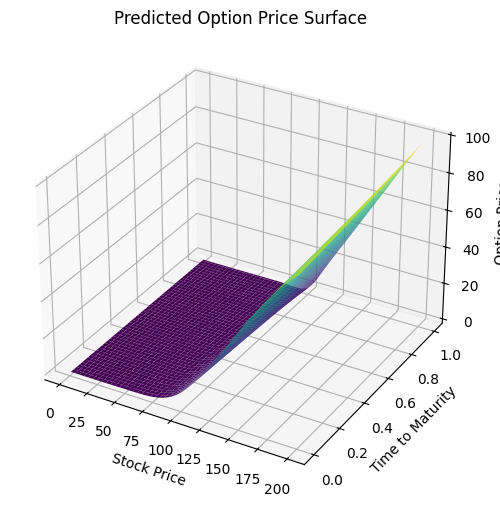

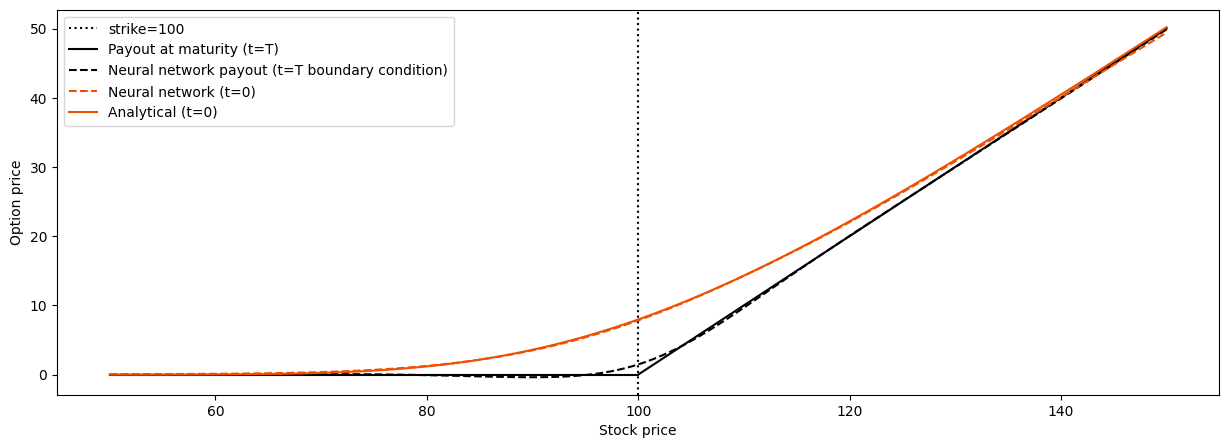

In [6]:
plot_surface(model)
plot(model, strike=strike, T=T, sigma=sigma)